## Google Data Analytics Capstone Project: Cyclistic

In Cyclistic, there are two types of members- annual members (people who have purchased annual subscriptions) and casual riders (users who buy passes for a single ride or full day). **The business ask is to convert casual riders to annual members to maximize company success.** Hence the major question for this data analysis is: **how the annual members and csual riders use Cyclistic bikes differently?** 

**Data Source: [divvy_tripdata](https://divvy-tripdata.s3.amazonaws.com/index.html)**

To keep things easier yet accurate, my analysis is focused on data from the last 12 months, for which I downloaded 12 zipped files (from Nov 2022 through October 2023).

### Conbining the Data Files

I have 12 zipped files in a folder called "raw_data", each zipped file can be uncompressed to another folder that contains one folder and one csv file. 
The below code will unzip the 12 zip files, store the 12 csv files into a new folder called "csv_files", and create a pandas df to store the combined data from the 12 csv files, and save the combined data into a new csv file.

In [1]:
import os
import zipfile

import pandas as pd
import numpy as np


# Create a new folder to store the csv files
if not os.path.exists('csv_files'):
    os.makedirs('csv_files')

# Unzip the 12 zip files
for filename in os.listdir('raw_data'):
    if filename.endswith('.zip'):
        with zipfile.ZipFile('raw_data/' + filename, 'r') as zip_ref:
            zip_ref.extractall('csv_files')

# Combine the data from the 12 csv files into a pandas dataframe
data = []
for filename in os.listdir('csv_files'):
    if filename.endswith('.csv'):
        with open('csv_files/' + filename, 'r') as f:
            data.append(pd.read_csv(f))

df = pd.concat(data)
df = df.drop_duplicates()

# Save the dataframe to a csv file
df.to_csv('combined_data.csv', index=False)

### Data Exploration

In [2]:
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,BCC66FC6FAB27CC7,electric_bike,2022-11-10 06:21:55,2022-11-10 06:31:27,Canal St & Adams St,13011,St. Clair St & Erie St,13016,41.879401,-87.639848,41.894345,-87.622798,member
1,772AB67E902C180F,classic_bike,2022-11-04 07:31:55,2022-11-04 07:46:25,Canal St & Adams St,13011,St. Clair St & Erie St,13016,41.879255,-87.639904,41.894345,-87.622798,member
2,585EAD07FDEC0152,classic_bike,2022-11-21 17:20:29,2022-11-21 17:34:36,Indiana Ave & Roosevelt Rd,SL-005,St. Clair St & Erie St,13016,41.867888,-87.623041,41.894345,-87.622798,member
3,91C4E7ED3C262FF9,classic_bike,2022-11-25 17:29:34,2022-11-25 17:45:15,Indiana Ave & Roosevelt Rd,SL-005,St. Clair St & Erie St,13016,41.867888,-87.623041,41.894345,-87.622798,member
4,709206A3104CABC8,classic_bike,2022-11-29 17:24:25,2022-11-29 17:42:51,Indiana Ave & Roosevelt Rd,SL-005,St. Clair St & Erie St,13016,41.867888,-87.623041,41.894345,-87.622798,member


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5652827 entries, 0 to 5652826
Data columns (total 13 columns):
 #   Column              Dtype  
---  ------              -----  
 0   ride_id             object 
 1   rideable_type       object 
 2   started_at          object 
 3   ended_at            object 
 4   start_station_name  object 
 5   start_station_id    object 
 6   end_station_name    object 
 7   end_station_id      object 
 8   start_lat           float64
 9   start_lng           float64
 10  end_lat             float64
 11  end_lng             float64
 12  member_casual       object 
dtypes: float64(4), object(9)
memory usage: 560.7+ MB


Notice that the numeric data fields in the orignal dataset are all about longtitude/lattitude. We would need data preprocessing to create our own numerical data fields for analysis.

In [4]:
# quick examination of non-numeric data fields
df.select_dtypes(object).describe().T

,count,unique,top,freq
ride_id,5652827,5652827,BCC66FC6FAB27CC7,1
rideable_type,5652827,3,electric_bike,2933508
started_at,5652827,4764981,2023-07-13 17:38:08,8
ended_at,5652827,4776456,2023-08-03 07:16:39,15
start_station_name,4786584,1579,Streeter Dr & Grand Ave,63213
start_station_id,4786452,1494,13022,63213
end_station_name,4734031,1589,Streeter Dr & Grand Ave,64312
end_station_id,4733890,1503,13022,64312
member_casual,5652827,2,member,3598046


In [5]:
# Quick examination of the unique values for some particular categorical data points: rideable type, user type

df.rideable_type.unique(), df.member_casual.unique()

(array(['electric_bike', 'classic_bike', 'docked_bike'], dtype=object),
 array(['member', 'casual'], dtype=object))

### Data Preprocessing

In [6]:
# convert from string to datetime, and calculate time duration in minute
from datetime import datetime

df['started_at'] = pd.to_datetime(df['started_at'])
df['ended_at'] = pd.to_datetime(df['ended_at'])

df['duration'] = (df['ended_at'] - df['started_at']).dt.total_seconds()/60

In [7]:
# Find "day of week" for started_at date
df['start_dayname'] = df.started_at.dt.day_name()

In [8]:
#  Find Season 

# df['season'] = np.where(df['started_at'].dt.month.between(3,5), 'Spring',
#                         np.where(df['started_at'].dt.month.between(6,8), 'Summer',
#                                  np.where (df['started_at'].dt.month.between(9,11), 'Fall', 'Winter')
#                                 )
#                        )

b = [1,3,6,9,12,13] # 13 is a dummy threshold
l = ['Winter', 'Spring','Summer','Fall','Winter']

df['season'] = pd.cut(df.started_at.dt.month, bins = b, labels = l, include_lowest = True, right = False, ordered=False)

df.sample()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,duration,start_dayname,season
1536340,D73E3F466EAFAC10,electric_bike,2023-04-19 22:46:15,2023-04-19 22:50:36,Halsted St & Roscoe St,TA1309000025,Broadway & Sheridan Rd,13323,41.94366,-87.648972,41.952833,-87.649993,member,4.35,Wednesday,Spring


In [10]:
df.select_dtypes(['object','category']).describe().T

,count,unique,top,freq
ride_id,5652827,5652827,BCC66FC6FAB27CC7,1
rideable_type,5652827,3,electric_bike,2933508
start_station_name,4786584,1579,Streeter Dr & Grand Ave,63213
start_station_id,4786452,1494,13022,63213
end_station_name,4734031,1589,Streeter Dr & Grand Ave,64312
end_station_id,4733890,1503,13022,64312
member_casual,5652827,2,member,3598046
start_dayname,5652827,7,Saturday,858700
season,5652827,4,Summer,2258961


### Data Analysis
**Questions to explore: Behavioral differences between the two types of customers (member vs casual)**

- Number of trips by user types

- Average trip duration (in minutes) by user types

- Top start stations for both types of users

- Rideable types used by both types of users

- Number of trips in different parts of the day by user types

- Number of trips on different days of the week by user types

- Number of trips in different seasons by user types

member    3598046
casual    2054781
Name: member_casual, dtype: int64


<Axes: ylabel='member_casual'>

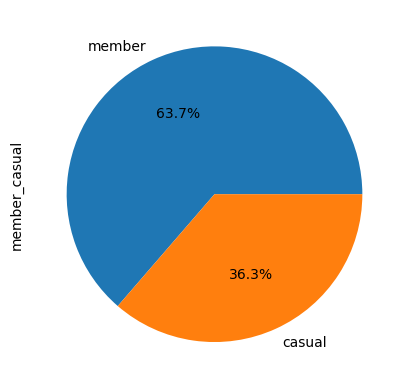

In [11]:
### 1. Number of trips based on user types
print(df.member_casual.value_counts())

df.member_casual.value_counts().plot(kind = 'pie', autopct='%1.1f%%')

<Axes: ylabel='member_casual'>

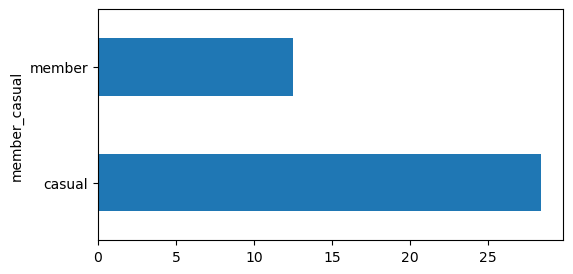

In [14]:
### 2. Average trip duration in minutes by user types
df.groupby('member_casual').duration.mean().plot(kind = 'barh', figsize = (6,3))

Notice that **casual riders travel 2X longer durations but less frequently than members.**

In [15]:
### 3. Top Starting Stations by user_type (casual vs member)
df.pivot_table(index = 'start_station_name', columns = 'member_casual', values='ride_id', aggfunc='count' )\
.sort_values(by='casual', ascending=False).head(10)

member_casual,casual,member
start_station_name,,
Streeter Dr & Grand Ave,46186.0,17027.0
DuSable Lake Shore Dr & Monroe St,30323.0,9723.0
Michigan Ave & Oak St,22525.0,14632.0
Millennium Park,20256.0,9858.0
DuSable Lake Shore Dr & North Blvd,20256.0,15564.0
Shedd Aquarium,17777.0,4983.0
Theater on the Lake,16327.0,13620.0
Dusable Harbor,15153.0,5855.0
Wells St & Concord Ln,12185.0,20991.0


In [16]:
## Top Starting Stations for casual users
df.query("member_casual == 'member'").start_station_name.value_counts().head(10)

Kingsbury St & Kinzie St        25458
Clinton St & Washington Blvd    25027
Clark St & Elm St               24481
Wells St & Concord Ln           20991
University Ave & 57th St        20276
Wells St & Elm St               19968
Clinton St & Madison St         19688
Ellis Ave & 60th St             18845
Broadway & Barry Ave            18703
Loomis St & Lexington St        18540
Name: start_station_name, dtype: int64

In [17]:
### 4. Number of trips in different rideable by user_type (rideable_type)

# df.pivot_table(index = 'rideable_type', columns = 'member_casual', values='ride_id', aggfunc='count')

pd.crosstab(df.rideable_type,df.member_casual)

member_casual,casual,member
rideable_type,,
classic_bike,859572,1773649
docked_bike,86098,0
electric_bike,1109111,1824397


<Axes: xlabel='Hour of Day'>

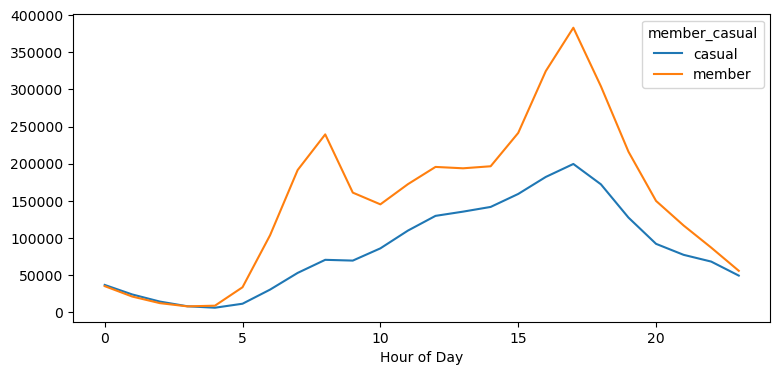

In [27]:
### 5. Number of trips in different parts of the day (Late Night, Morning,Afternoon,Evening,Night) by user types

# print(df.pivot_table(index = 'day_session', columns = 'member_casual', values='ride_id', aggfunc='nunique'))

pd.crosstab(df.started_at.dt.hour, df.member_casual)\
.plot(figsize = (9,4), xlabel = 'Hour of Day')

**Members prefer riding bikes during commute hours (peaks around 8am and 5pm), while casual riders use bike throughout the day (more frequently in the afternoon).**

<Axes: xlabel='Day of Week (Monday to Sunday)'>

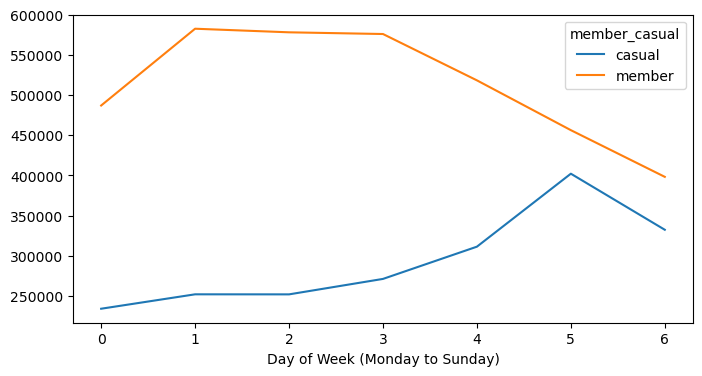

In [23]:
### 6. Number of trips on different days of the week by user types
df.pivot_table(index =df.started_at.dt.weekday, columns = 'member_casual', values='ride_id', aggfunc='nunique')\
.plot(figsize = (8,4), xlabel = 'Day of Week (Monday to Sunday)')

Notice the signficant behavioral difference between member and casual riders: **members prefer weekdays, while casual users perfer Saturday and Sunday.**

In [24]:
### 7. Number of trips in different seasons (spring, summer, fall, winter) by user types
# df.pivot_table(index = 'season', columns = 'member_casual', values='ride_id', aggfunc='count')
pd.crosstab(df.season, df.member_casual)\
.sort_values(by = 'casual', ascending = False)

member_casual,casual,member
season,,
Summer,943718,1315243
Fall,539478,1001741
Spring,443667,846428
Winter,127918,434634


In [25]:
### 8. Number of trips in different months by user types
pd.crosstab(df.started_at.dt.month_name(), df.member_casual)\
.sort_values(by = 'casual', ascending = False)

member_casual,casual,member
started_at,,
July,331358,436292
August,311130,460563
June,301230,418388
September,261635,404736
May,234181,370646
October,177071,360042
April,147285,279305
November,100772,236963
March,62201,196477


<Axes: xlabel='Month'>

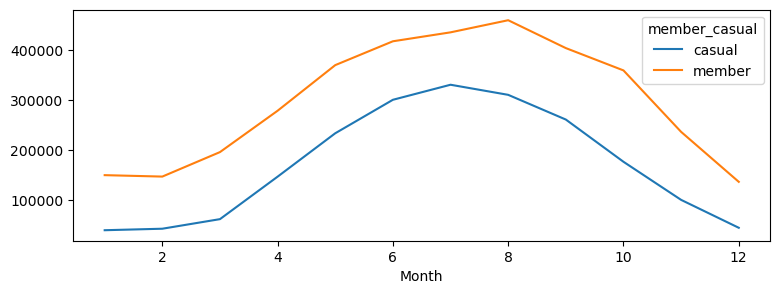

In [29]:
pd.crosstab(df.started_at.dt.month, df.member_casual).plot(figsize = (9,3), xlabel = 'Month')

Both members and casual riders use bikes in summer mostly, and many of them uses Cyclistic freqently during spring and fall too. July is casual riders' favorite while August is members' favorite.

### Findings and recommendations
Based on the analysis, casual riders prefer using bikes over the weekends (especially Saturday) and they use bikes throughout the day (especially active in the afternoon). In contrast, members prefer riding bikes on weekdays during commute hours(8am and 5pm). 
Both members and casual riders use bikes in summer mostly, and many of them uses Cyclistic freqently during spring and fall too. July is Casual riders' favorite while August is members' favorite.
Also, casual riders travel less freqeuntly but longer rides than members (approximately 2X member riders' trip duration).

The data suggests that, if casual users can be turned into members, the use of bikes will increase in almost all parts of the day, all days of the week, and a minimum of three seasons of the year. To turn casual users into members, the suggestions would be:

- Offering incentives/special gifts on weekend rides by members only.
- Offering discounts for new subscriptions during spring and summer (say April, May, and June).


Weekend-only or seasonal incentives/discounts will attract casual users to buy memberships as they are most active on weeknds and during summer and spring. As the membership is offered at a discounted price, more of the casual riders would like to buy it.

- The marketing campaigns should be conducted heavily in spring and summer around the top stations for casual riders, such as Streeter Dr & Grand Ave, DuStable Lake Shore Dr & Monroe St, Millennium Park, Michigan Ave & Oak St, DuStable Lake Shore Dr & North Blvd, and Shedd Aquarium.

- Lastly, offering discounts for longer riders may incentivize casual riders or encourage members to ride for longer time.